<a href="https://colab.research.google.com/github/Pravallika41296/IANNWTF_Homework_Group24/blob/gh-pages/IANNWTF_Homework08_Group24_Vedant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import pandas as pd
import time

from tensorflow.keras import layers, losses
from sklearn.manifold import TSNE 
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
output_notebook()

In [71]:
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print (x_train.shape)
print (x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


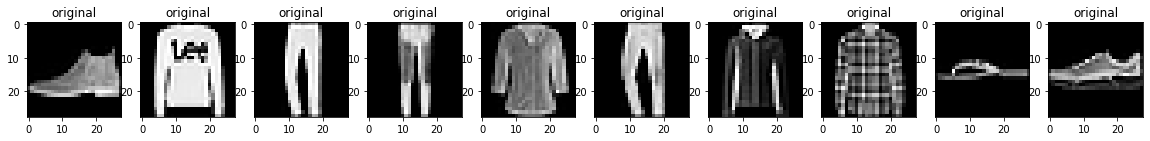

In [72]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

In [142]:

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = tf.keras.Sequential()
    self.model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    self.model.add(layers.BatchNormalization())
    self.model.add(layers.LeakyReLU())

    self.model.add(layers.Reshape((7, 7, 256)))

    self.model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    self.model.add(layers.BatchNormalization())
    self.model.add(layers.LeakyReLU())

    self.model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    self.model.add(layers.BatchNormalization())
    self.model.add(layers.LeakyReLU())

    self.model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))

  def call(self, x):
    output = self.model(x)
    return output

In [143]:

class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = tf.keras.Sequential()
    self.model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    self.model.add(layers.LeakyReLU())
    self.model.add(layers.Dropout(0.3))

    self.model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    self.model.add(layers.LeakyReLU())
    self.model.add(layers.Dropout(0.3))

    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(1))

  def call(self, x):
    output = self.model(x)
    return output

In [75]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [76]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [77]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [78]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [144]:
generator = Generator()
discriminator = Discriminator()

In [80]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [145]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [146]:

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [147]:
g_loss = []
d_loss = []
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(gen_loss, disc_loss)
    g_loss.append(gen_loss)
    d_loss.append(disc_loss)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [148]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [149]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Time for epoch 1 is 17.43057155609131 sec
tf.Tensor(1.2063495, shape=(), dtype=float32) tf.Tensor(0.9006042, shape=(), dtype=float32)
Time for epoch 2 is 17.167333841323853 sec
tf.Tensor(1.1539117, shape=(), dtype=float32) tf.Tensor(1.0066092, shape=(), dtype=float32)
Time for epoch 3 is 17.304506540298462 sec
tf.Tensor(1.1702548, shape=(), dtype=float32) tf.Tensor(1.0117835, shape=(), dtype=float32)
Time for epoch 4 is 17.58214020729065 sec
tf.Tensor(0.95437926, shape=(), dtype=float32) tf.Tensor(1.2157048, shape=(), dtype=float32)
Time for epoch 5 is 17.732185125350952 sec
tf.Tensor(1.2377075, shape=(), dtype=float32) tf.Tensor(0.90287685, shape=(), dtype=float32)
Time for epoch 6 is 17.702120542526245 sec
tf.Tensor(1.0785654, shape=(), dtype=float32) tf.Tensor(1.2133584, shape=(), dtype=float32)
Time for epoch 7 is 17.666504383087158 sec
tf.Tensor(1.0199182, shape=(), dtype=float32) tf.Tensor(1.2653306, shape=(), dtype=float32)
Time for epoch 8 is 17.645225048065186 sec
tf.Tensor(1.

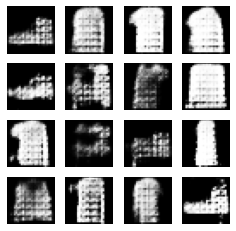

In [150]:

train(train_dataset, EPOCHS)


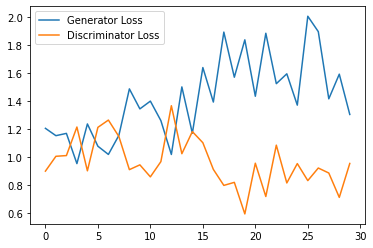

In [151]:
plt.plot(g_loss, label="Generator Loss")
plt.plot(d_loss, label="Discriminator Loss")
plt.legend()

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size = 64,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0192 - val_loss: 0.0078
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0028

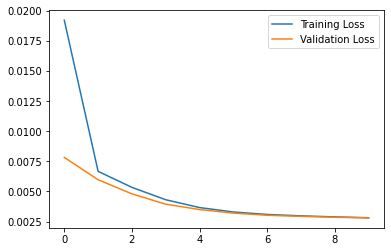

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable pa

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

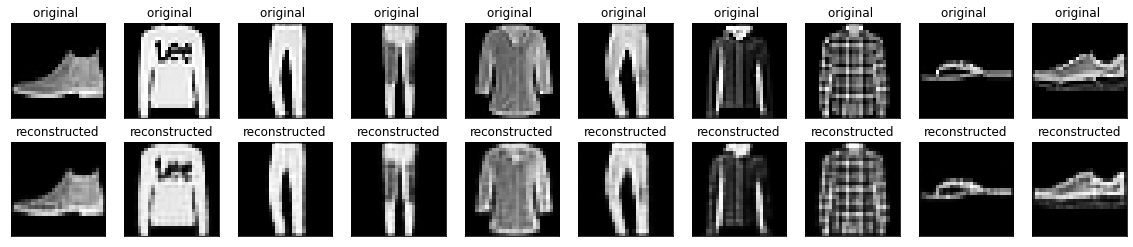

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original ")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
test_images = np.array(decoded_imgs)
print(test_images.shape)
nsamples, nx, ny, _ = test_images.shape
d2_test_dataset = test_images.reshape((nsamples,nx*ny))
print(d2_test_dataset.shape)
test_images = d2_test_dataset[:1000]
tsne = TSNE(n_components=2, random_state=0)
tsne_fashion = tsne.fit_transform(test_images)
print(tsne_fashion)

(10000, 28, 28, 1)
(10000, 784)
[[-39.757416    5.6012387]
 [ 16.05815    23.969267 ]
 [  7.7178144 -41.13995  ]
 ...
 [ 21.642689   30.32756  ]
 [-33.606434  -15.014925 ]
 [-41.99039   -16.272488 ]]


In [ ]:
test = []
y_test = y_test[:1000]
for i in range(len(y_test)):
  test.append(str(y_test[i]))
d = {'v' : test}
d = pd.DataFrame(d)
d = d['v'].map({'1': '#ff8000','2': '#40ff00','3': '#0080ff', '4':'#00ffbf', '5':'#ff0000', '6': '#EDBB99', '7': '#CD5C5C', '8': '#B7950B', '9':'#EDBB99', '0':'#A9DFBF'})
d = list(d)
print(d)


['#EDBB99', '#40ff00', '#ff8000', '#ff8000', '#EDBB99', '#ff8000', '#00ffbf', '#EDBB99', '#ff0000', '#CD5C5C', '#00ffbf', '#ff0000', '#CD5C5C', '#0080ff', '#00ffbf', '#ff8000', '#40ff00', '#00ffbf', '#B7950B', '#A9DFBF', '#40ff00', '#ff0000', '#CD5C5C', '#EDBB99', '#ff8000', '#00ffbf', '#EDBB99', '#A9DFBF', '#EDBB99', '#0080ff', '#B7950B', '#B7950B', '#0080ff', '#0080ff', '#B7950B', '#A9DFBF', '#CD5C5C', '#ff0000', '#CD5C5C', '#EDBB99', '#EDBB99', '#ff8000', '#0080ff', '#CD5C5C', '#EDBB99', '#CD5C5C', '#40ff00', '#ff8000', '#40ff00', '#40ff00', '#00ffbf', '#00ffbf', '#ff0000', '#B7950B', '#40ff00', '#40ff00', '#B7950B', '#00ffbf', '#B7950B', '#A9DFBF', '#CD5C5C', '#CD5C5C', '#B7950B', '#ff0000', '#ff8000', '#ff8000', '#40ff00', '#0080ff', '#EDBB99', '#B7950B', '#CD5C5C', '#A9DFBF', '#40ff00', '#EDBB99', '#40ff00', '#0080ff', '#ff8000', '#40ff00', '#B7950B', '#00ffbf', '#ff8000', '#B7950B', '#ff0000', '#EDBB99', '#ff0000', '#A9DFBF', '#0080ff', '#40ff00', '#A9DFBF', '#EDBB99', '#ff0000'

In [ ]:
p = figure(title="Fashion")

source = ColumnDataSource(data=dict(x1=tsne_fashion[:,0],
                                    x2=tsne_fashion[:,1], color = d,
                                    names=tsne_fashion))

p.scatter(x="x1", y="x2", size=8, source=source, color="color")
show(p)

In [ ]:
test_images = np.array(x_test)
print(test_images.shape)
nsamples, nx, ny, _ = test_images.shape
d2_test_dataset = test_images.reshape((nsamples,nx*ny))
print(d2_test_dataset.shape)
test_images = d2_test_dataset[:1000]
tsne = TSNE(n_components=2, random_state=0)
tsne_fashion = tsne.fit_transform(test_images)
print(tsne_fashion)
test = []
y_test = y_test[:1000]
for i in range(len(y_test)):
  test.append(str(y_test[i]))
d = {'v' : test}
d = pd.DataFrame(d)
d = d['v'].map({'1': '#ff8000','2': '#40ff00','3': '#0080ff', '4':'#00ffbf', '5':'#ff0000', '6': '#EDBB99', '7': '#CD5C5C', '8': '#B7950B', '9':'#EDBB99', '0':'#A9DFBF'})
d = list(d)
print(d)
p = figure(title="Fashion")

source = ColumnDataSource(data=dict(x1=tsne_fashion[:,0],
                                    x2=tsne_fashion[:,1], color = d,
                                    names=tsne_fashion))

p.scatter(x="x1", y="x2", size=8, source=source, color="color")
show(p)

(10000, 28, 28, 1)
(10000, 784)
[[-28.916035  -17.765526 ]
 [ -3.9445224  31.72353  ]
 [ 40.80186   -17.561583 ]
 ...
 [ -5.0031447  37.828186 ]
 [-10.475471  -27.833578 ]
 [-14.868921  -31.418564 ]]
['#EDBB99', '#40ff00', '#ff8000', '#ff8000', '#EDBB99', '#ff8000', '#00ffbf', '#EDBB99', '#ff0000', '#CD5C5C', '#00ffbf', '#ff0000', '#CD5C5C', '#0080ff', '#00ffbf', '#ff8000', '#40ff00', '#00ffbf', '#B7950B', '#A9DFBF', '#40ff00', '#ff0000', '#CD5C5C', '#EDBB99', '#ff8000', '#00ffbf', '#EDBB99', '#A9DFBF', '#EDBB99', '#0080ff', '#B7950B', '#B7950B', '#0080ff', '#0080ff', '#B7950B', '#A9DFBF', '#CD5C5C', '#ff0000', '#CD5C5C', '#EDBB99', '#EDBB99', '#ff8000', '#0080ff', '#CD5C5C', '#EDBB99', '#CD5C5C', '#40ff00', '#ff8000', '#40ff00', '#40ff00', '#00ffbf', '#00ffbf', '#ff0000', '#B7950B', '#40ff00', '#40ff00', '#B7950B', '#00ffbf', '#B7950B', '#A9DFBF', '#CD5C5C', '#CD5C5C', '#B7950B', '#ff0000', '#ff8000', '#ff8000', '#40ff00', '#0080ff', '#EDBB99', '#B7950B', '#CD5C5C', '#A9DFBF', '#40ff0